In [4]:
from keras_unet.models import custom_unet
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import KFold
import mlflow
import os
import numpy as np
import keras_unet
import patchify
import imgaug
import imgaug.augmenters as iaa
import json
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
%matplotlib inline
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Get targets and labels

### For image data:

In [5]:
working_directory = os.getcwd()
target_directory = f'{working_directory}/data_360/images/'
label_directory = f'{working_directory}/labels/2021-12-18/SegmentationClass/'

target_filenames_for_check = sorted([item for item in os.listdir(target_directory) if ".JPG" in item])
label_filenames = sorted([item for item in os.listdir(label_directory) if ".png" in item])
n_targets = len(target_filenames_for_check)
n_labels = len(label_filenames)

labels_found = 0
labels_not_found = 0
for label_filename in label_filenames:
    if label_filename.replace('.png', '.JPG') in target_filenames_for_check:
        labels_found += 1
    else:
        labels_not_found += 1

print(f'Number of target images: {n_targets}')
print(f'Number of labels: {n_labels}')
print(f'Target images corresponding to labels found: {labels_found}, not found: {labels_not_found}')

target_filepaths = [ f'{target_directory}/{label_filename.replace(".png", ".JPG")}' for label_filename in label_filenames]
label_filepaths = [ f'{label_directory}/{label_filename}' for label_filename in label_filenames]

Number of target images: 10866
Number of labels: 1029
Target images corresponding to labels found: 1029, not found: 0


### Sanity check for Image loading

In [6]:
test_target_image = Image.open(target_filepaths[3])
test_label_image = Image.open(label_filepaths[3])
print(f'Target image dimensions: {test_target_image.size[0]} x {test_target_image.size[1]}')
print(f'Label image dimensions: {test_label_image.size[0]} x {test_label_image.size[1]}')

Target image dimensions: 5760 x 2880
Label image dimensions: 5760 x 2880


In [7]:
test_target_numpy = np.asarray(test_target_image)
test_label_numpy = np.asarray(test_label_image)
print(f'Target image value range: ({test_target_numpy.min()}, {test_target_numpy.max()})')
print(f'Label image value range: ({test_label_numpy.min()}, {test_label_numpy.max()})')

Target image value range: (0, 255)
Label image value range: (0, 255)


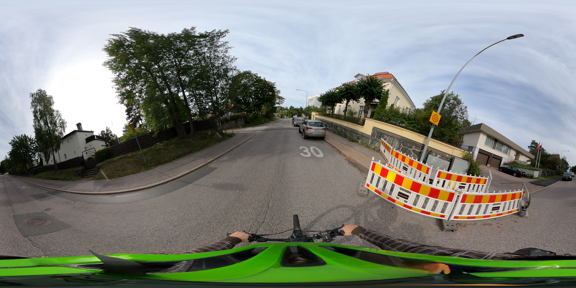

In [8]:
test_target_image.resize((576, 288))

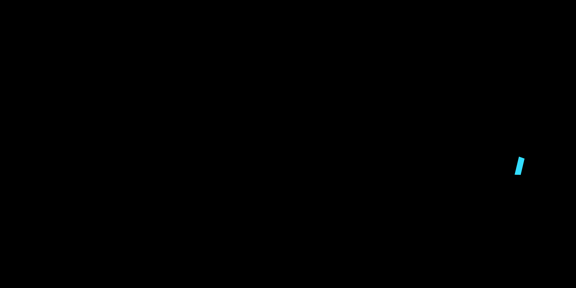

In [9]:
test_label_image.resize((576, 288))

### For .npz data:
(Do NOT execute if you want to use image data)

In [10]:
working_directory = os.getcwd()
target_directory = f'{working_directory}/data_perspective_corrected/patches/'
label_directory = f'{working_directory}/labels/perspective_corrected/patches/'

target_filenames_for_check = [item for item in os.listdir(target_directory) if ".npz" in item]
label_filenames = [item for item in os.listdir(label_directory) if ".npz" in item]
n_targets = len(target_filenames_for_check)
n_labels = len(label_filenames)

labels_found = 0
labels_not_found = 0
for label_filename in label_filenames:
    if label_filename in target_filenames_for_check:
        labels_found += 1
    else:
        labels_not_found += 1

print(f'Number of target images: {n_targets}')
print(f'Number of labels: {n_labels}')
print(f'Target images corresponding to labels found: {labels_found}, not found: {labels_not_found}')

target_filepaths = [ f'{target_directory}/{label_filename}' for label_filename in label_filenames]
label_filepaths = [ f'{label_directory}/{label_filename}' for label_filename in label_filenames]

Number of target images: 8040
Number of labels: 8040
Target images corresponding to labels found: 8040, not found: 0


### Sanity check for .npz loading

Target shape: (480, 480, 3)
Label shape: (480, 480, 3)


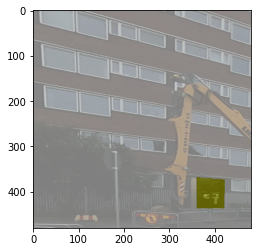

In [11]:
a_label = np.load(label_filepaths[0])['arr_0']
a_target = np.load(target_filepaths[0])['arr_0']

print(f'Target shape: {a_target.shape}')
print(f'Label shape: {a_label.shape}')

label_img = np.abs((a_label / 255) - 1) * 0.5
img = (a_target / 255 * 0.5) + label_img 
plt.imshow(img)

# Options

In [12]:
input_shape = (480, 480, 3)

label_rgbs = {
    "background": [0,0,0],
    "porras": [255,106,77],
    "portti": [51,221,255],
    "porttikäytävä": [255,204,51],
    "rapputunnus": [131,224,112],
    "sisäänkäynti": [61,61,245],
}


affine_translation_opts = {
    'rotate': (-30, 30),
    'translate_percent': {
        'x': (-0.1, 0.1),
        'y': (-0.1, 0.1)
    },
    'shear': {
        'x': (-10, 10),
        'y': (-10, 10)
    }
}

data_generator_options = {
    'original_image_dimensions': (5760, 2880),
    'patch_size_square': input_shape[0],
    'batch_size': 5,
    'data_format': 'npz'
}

model_options = {
    'input_shape': input_shape,
    'use_batch_norm': True,
    'num_classes': len(label_rgbs),
    'filters': 64,
    'dropout': 0.2,
    'output_activation': 'softmax'
}

fit_options = {
    "epochs": 100,
    "use_multiprocessing": True
}
run_name = '2022-01-03-heavier-augmentations'
model_checkpoint_path = f'./model_checkpoints/checkpoint/${run_name}/checkpoint'
os.mkdir(f'imgs/{run_name}')

FileExistsError: [Errno 17] File exists: 'imgs/2022-01-03-heavier-augmentations'

# Train/Validation split and Data generator
Let's start with naive train/validation split and later build it into a proper K-fold Cross Validation scheme

### TODO: K-fold Cross Validation

In [13]:
n_validation_images = len(label_filepaths) // 20
n_train_images = len(label_filepaths) - n_validation_images
print(f'Training set size: {n_train_images}, validation set size: {n_validation_images}')

partition = {
    'train': label_filenames[0 : n_train_images],
    'validation': label_filenames[n_train_images :]
}

print(f'Partition sizes: train={len(partition["train"])}, validation={len(partition["validation"])}') 

for filename in partition['train']:
    if filename in partition['validation']:
        print(f'Indexing error, file {filename} is in both training and validation sets')


Training set size: 7638, validation set size: 402
Partition sizes: train=7638, validation=402


In [21]:
import re
pattern = re.compile('(.*)_[left|right|back|front|top|bottom].*')
sorted(set([re.search(pattern, filepath).group(1) for filepath in partition['validation']]))

 '20210914-kruununhaka_GSAH0691',
 '20210914-kruununhaka_GSAH0692',
 '20210914-kruununhaka_GSAH0693',
 '20210914-kruununhaka_GSAH0694',
 '20210914-kruununhaka_GSAH0695',
 '20210914-kruununhaka_GSAH0696',
 '20210914-kruununhaka_GSAH0699',

['20210914-kruununhaka_GSAD0187',
 '20210914-kruununhaka_GSAD0305',
 '20210914-kruununhaka_GSAD0315',
 '20210914-kruununhaka_GSAD0438',
 '20210914-kruununhaka_GSAE0448',
 '20210914-kruununhaka_GSAE0458',
 '20210914-kruununhaka_GSAE0459',
 '20210914-kruununhaka_GSAE0461',
 '20210914-kruununhaka_GSAE0478',
 '20210914-kruununhaka_GSAE0479',
 '20210914-kruununhaka_GSAE0484',
 '20210914-kruununhaka_GSAE0485',
 '20210914-kruununhaka_GSAE0486',
 '20210914-kruununhaka_GSAE0495',
 '20210914-kruununhaka_GSAE0498',
 '20210914-kruununhaka_GSAE0501',
 '20210914-kruununhaka_GSAE0505',
 '20210914-kruununhaka_GSAE0507',
 '20210914-kruununhaka_GSAE0509',
 '20210914-kruununhaka_GSAE0510',
 '20210914-kruununhaka_GSAE0513',
 '20210914-kruununhaka_GSAE0514',
 '20210914-kruununhaka_GSAE0528',
 '20210914-kruununhaka_GSAE0529',
 '20210914-kruununhaka_GSAE0532',
 '20210914-kruununhaka_GSAE0546',
 '20210914-kruununhaka_GSAE0551',
 '20210914-kruununhaka_GSAE0554',
 '20210914-kruununhaka_GSAE0556',
 '20210914-kru

### TODO: 
    - patch imagespatches_in_single_image
        - patching has a small bug where it looks like batch sizes are actually batch_size + 2
    - image augmentation
    - for some reason Keras thinks we give it 32 image batches, but that is actually just... one image.

In [71]:
label_to_target_map = None
with open('labels-to-targets-map.json') as tlmap:
    label_to_target_map = json.load(tlmap)

augment_sequence = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
#    iaa.Dropout((0.01, 0.1)),
    iaa.Sharpen((0.0, 1.0)),
    iaa.Affine(**affine_translation_opts),
    iaa.ElasticTransformation(alpha=(0, 10), sigma=5),
    iaa.Multiply((0.75, 1.25)),
    iaa.CoarseDropout(0.02, size_percent=0.05)
], random_order = True)
    

class DataGenerator(keras.utils.Sequence):
    """
        Generate augmented (target, label) pairs for Keras.
    """
    def __init__(
        self, 
        list_IDs,
        target_directory,
        label_directory,
        label_rgbs,
        patch_size_square=512, # ATM we only use square images, so only need to find out the size of one side
        original_image_dimensions=(512, 512),
        n_channels=3,
        batch_size=4,
        shuffle=True,
        augment=True,
        debug=False,
        data_format='image' # 'npz' or 'image',
    ):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.num_target_classes = len(label_rgbs)
        self.patch_size_square = patch_size_square
        self.original_image_dimensions = original_image_dimensions
        self.n_channels = n_channels
        self.target_directory = target_directory
        self.label_directory = label_directory
        self.label_rgbs = label_rgbs
        self.label_onehot = self.label_onehot_from_label_rgbs(label_rgbs)
        self.shuffle = shuffle
        self.augment = augment
        self.debug = debug
        self.data_format = data_format
        self.on_epoch_end()
        
    def __len__(self):
        """
            Number of batches per epoch
        """
        if self.data_format == 'image':
            n_images = len(self.list_IDs)
            patches_in_image = self.__n_patches_in_single_image__()
            total_patches = patches_in_image * n_images
            length = int(np.ceil(total_patches / self.batch_size))
            return length
        # If self.data_format is 'npz':
        n_images = len(self.list_IDs)
        return n_images // self.batch_size
    
    
    def __n_patches_in_single_image__(self):
        patches_in_image_x = int(np.ceil(self.original_image_dimensions[0] / self.patch_size_square))
        patches_in_image_y = int(np.ceil(self.original_image_dimensions[1] / self.patch_size_square))
        patches_total = patches_in_image_x * patches_in_image_y
        return(patches_total)
    
    def rgb_to_onehot(self, img):
        """
            @img = M*N*Channels (e.g. 512 * 512 * 3 for a 512x512 pixel RGB image) numpy array
        """
        layout_x, layout_y, _ = img.shape
        layout = np.zeros((layout_x, layout_y, len(self.label_onehot[0])))
        for i, label in enumerate(self.label_rgbs):
            layout[np.all(img == label, axis = -1)] = self.label_onehot[i]
        return layout
    

    def label_onehot_from_label_rgbs(self, labels):
        """
            Create onehot labels from label RGBs, e.g.
            
            Input: 
            { "human": [255, 255, 255], "dog": [125, 125 ,125], "background": [0, 0, 0]}
            
            Output:
            [
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]
            
            FIXME: just use np.identity, d'oh
        """
        layout = []
        size = len(labels)
        k = 0
        for i in range(0, size):
            vec = [0] * size
            for j in range(0, size):
                if j == k:
                    vec[j] = 1
            k += 1
            layout.append(vec)
        return layout
    
    def on_epoch_end(self):
        """
        Update indexes after each epoch
        
        FIXME: ATM does nothing
        """
        # Image shuffle not implemented yet
        if not self.data_format == 'image':
            np.random.shuffle(self.list_IDs)
            
        
    def __index_to_img_patch_index__(self, start_index, end_index):
        """
        Translate start index and end index into 
        a list of {image index, patch start index, patch end index}.
        
        For example, suppose there are four patches in an image.
        Now a call for __index_to_img_patch_index__(2, 6) would return
        [
            { img_index: 0, patch_start: 2, patch_end: 3}, # zero-indexed, so 3 is last
            { img_index: 1, patch_start: 0, patch_end: 2}
        ]
        """
        patches_in_image = self.__n_patches_in_single_image__()
        start_image_index = start_index // patches_in_image
        end_image_index = end_index // patches_in_image
        indexes = []
        patch_index = start_index
        for idx in range(start_image_index, end_image_index + 1):
            if idx < len(self.list_IDs):
                patch_start = patch_index % patches_in_image
                patch_end, patch_index = self.__calculate_patch_end__(patches_in_image, patch_index, end_index)
                indexes.append({'img_index': idx, 'patch_start': patch_start, 'patch_end': patch_end})
        return(indexes)

    def __calculate_patch_end__(self, n_patches_in_image, start_index, end_index):
        """
        n_patches_in_image: how many patches there are in an image
        start_index:        first image that should be included (starts from 0, inclusive)
        end_index:          last image that should be included (inclusive)
        
        Calculates how many patches can be included in the current image.
        """
        steps_required = end_index - start_index
        if (start_index % n_patches_in_image) + steps_required  >= n_patches_in_image:
            new_index = ((start_index // n_patches_in_image) + 1) * n_patches_in_image
            return (n_patches_in_image - 1, new_index)
        patch_end = max(end_index % n_patches_in_image, steps_required)
        return (patch_end, (end_index - start_index)) 

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size - 1

        if (self.data_format == 'image'):
            return self.__getitem_image__(start_index, end_index, index)
        return self.__getitem_npz__(start_index, end_index)
    
    def __getitem_npz__(self, start_index, end_index):
        """
        Generate one batch from .npz files
        """
        npz_labels_to_load = self.list_IDs[start_index:end_index+1]
        return self.__data_generation_from_npz__(npz_labels_to_load)
    
    def __getitem_image__(self, start_index, end_index, index):
            """
            Generate one image batch

            @index is the number of the batch
            """
            # Transform into [{img_index, patch_start, patch_end}]
            images_to_load = self.__index_to_img_patch_index__(start_index, end_index)
            images_to_load = [{**k, 'image': self.list_IDs[k["img_index"]]} for k in images_to_load]
            X, y = self.__data_generation_from_images__(images_to_load, index)
            return X, y
    
    def __calculate_batch_length__(self, images_to_load):
        total = 0
        for entry in images_to_load:
            total += entry['patch_end'] - entry['patch_start'] + 1
        return total    
    
    def __data_generation_from_npz__(self, npz_labels_to_load):
        X = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, self.n_channels))
        Y = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, self.num_target_classes))
        if self.debug:
            Y = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, 3))
            
        for i, npz_labelname in enumerate(npz_labels_to_load):
            target_filepath = f'{self.target_directory}{npz_labelname}'
            label_filepath = f'{self.label_directory}{npz_labelname}'
            if self.debug:
                print(f'Loaded target {target_filepath}, label {label_filepath}.')
            x = np.load(target_filepath)['arr_0'].astype('uint8')
            y = np.load(label_filepath)['arr_0'].astype('uint8')
            
            if self.augment:
                labelmap = imgaug.augmentables.segmaps.SegmentationMapsOnImage(y, shape=y.shape)
                [x, label_augmented_map] = augment_sequence(image = x, segmentation_maps = labelmap)
                y = label_augmented_map.arr
                    
            if not self.debug:
                y = self.rgb_to_onehot(y)
            x = x / 255
            X[i,] = x
            Y[i,] = y
        return (X, Y)
 
    
    def __data_generation_from_images__(self, images_to_load, index):
        X = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, self.n_channels))
        y = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, self.num_target_classes))
        if self.debug:
            y = np.empty((self.batch_size, self.patch_size_square, self.patch_size_square, 3))
        
        patches_in_single_image = self.__n_patches_in_single_image__()
        
        patch_index = 0
        for i, image_to_load in enumerate(images_to_load):
            target_filename = label_to_target_map[image_to_load["image"]]["image"]
            target_filepath = f'{self.target_directory}{target_filename}'
            label_filepath = f'{self.label_directory}{image_to_load["image"]}'
            if self.debug:
                print(f'Loaded target {target_filename}, label {image_to_load["image"]}.')
            target_img = np.asarray(Image.open(target_filepath))
            label_img = np.asarray(Image.open(label_filepath))

            # Create patches
            whole_target_image_patched = patchify.patchify(target_img, (self.patch_size_square, self.patch_size_square, 3), step=self.patch_size_square).reshape(patches_in_single_image, self.patch_size_square, self.patch_size_square, 3)
            whole_label_image_patched = patchify.patchify(label_img, (self.patch_size_square, self.patch_size_square, 3), step=self.patch_size_square).reshape(patches_in_single_image, self.patch_size_square, self.patch_size_square, 3)
            
            target_patches = whole_target_image_patched[image_to_load['patch_start']:image_to_load['patch_end'] + 1]
            label_patches = whole_label_image_patched[image_to_load['patch_start']:image_to_load['patch_end'] + 1]
            patches_in_image_x = self.original_image_dimensions[0] // self.patch_size_square

            for j, target_patch in enumerate(target_patches):
                label = label_patches[j]
                # Augment images
                if self.augment:
                    labelmap = imgaug.augmentables.segmaps.SegmentationMapsOnImage(label, shape=label.shape)
                    [target_patch, label_augmented_map] = augment_sequence(image = target_patch, segmentation_maps = labelmap)
                    label = label_augmented_map.arr
                
                if not self.debug:
                    label = self.rgb_to_onehot(label)
                X[patch_index,] = target_patch
                y[patch_index,] = label
                patch_index += 1
                
        #X = preprocess_input(X)
        return X, y


In [72]:
training_generator = DataGenerator(
    list_IDs = partition["train"],
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    **data_generator_options,
    augment=False
)
validation_generator = DataGenerator(
    list_IDs = partition["validation"],
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    **data_generator_options,
    augment=False
)




In [18]:
"""
keras.backend.clear_session()

model = custom_unet(**model_options)

learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.MeanIoU(num_classes=len(label_rgbs))
    ]
)
"""

model = keras.models.load_model('2021-12-31-light-augments-val-loss-0_085')

In [23]:
def prefix_dict_keys_with(prefix, adict):
    """
    Used with mlflow.log_params to provide better key names
    """
    return { f'{prefix}_{key}': value for key, value in adict.items() }

augments = {
    'fliplr': 0.5,
    'filpud': 0.5,
#    'dropout': (0.01, 0.1),
    'sharpen': (0.0, 1.0),
    'affine': affine_translation_opts,
    'elastict_transformation': {
        'alpha': (0, 10),
        'sigma': 5,
    },
    'multiply': (0.75, 1.25),
    'coarse_dropout': {
        'p': 0.02,
        'size_percent': 0.05
    },
    'random_order': True
}


mlflow.start_run(run_name=run_name)

#mlflow.tensorflow.autolog() # automatic mlflow tracking for tensorflow does not work, sometimes tries to log batch size 
mlflow.set_experiment('Training on perspective corrected, prepatched data')
mlflow.log_params(prefix_dict_keys_with('model_options', model_options))
mlflow.log_params(prefix_dict_keys_with('data_generator_options', data_generator_options))
mlflow.log_params(prefix_dict_keys_with('fit_options', fit_options))
mlflow.log_param('image_augments', augments)
mlflow.log_param('normalize_values', True)
mlflow.log_param('use_resnet50_preprocess_input', False)
mlflow.log_param('input_shape', input_shape)
mlflow.log_param('perspective_corrected', True)
mlflow.log_param('k_fold_cross_validation', False)
mlflow.log_param('balanced_dataset', True)
mlflow.log_param('checkpoint', model_checkpoint_path)
mlflow.log_param('optimizer', 'adam')
mlflow.log_param('learning_rate', learning_rate)
mlflow.log_param('loss', 'binary_crossentropy')
mlflow.log_param('metrics', 'keras.metrics.MeanIoU(num_classes=6)')

In [74]:

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

earlystopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)


class EpochPredictorCallback(keras.callbacks.Callback):
    
    def __init__(self, images):
        self.images = images

    def on_epoch_begin(self, epoch, _):
        model = self.model
        res = self.model.predict(self.images)
        n = len(self.images)
        fig, axs = plt.subplots(n, 7, figsize=(7*4, n*4), sharex=True, sharey=True)
        axs[0][0].set_title('original')
        for i, key in enumerate(label_rgbs.keys()):
            axs[0][i + 1].set_title(key)

        for j in range(0, n):
            axs[j][0].imshow(test2[j])

        for i in range(1, 7):
            for j in range(0, n):
                axs[j][i].matshow(res[j][:,:,i-1])
        n = str(epoch).zfill(3)
        plt.savefig(f'imgs/{run_name}/epoch-{n}.png')

class Logger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metric('train_loss', logs['loss'])
        mlflow.log_metric('train_mean_iou', logs['mean_io_u'])
        mlflow.log_metric('validation_loss', logs['val_loss'])
        mlflow.log_metric('validation_mean_iou', logs['val_mean_io_u'])
                          
logger_callback = Logger()

def learning_rate_scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learning_rate_callback = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
epoch_predictor_callback = EpochPredictorCallback(test2)

In [75]:
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    **fit_options,
    callbacks=[
        model_checkpoint_callback,
#        earlystopping_callback,
        learning_rate_callback,
        logger_callback,
        epoch_predictor_callback
    ]
)

Epoch 1/100
1527/1527 [==============================] - 967s 632ms/step - loss: 0.0166 - mean_io_u: 0.8920 - val_loss: 0.0978 - val_mean_io_u: 0.9030

Epoch 00001: val_mean_io_u improved from -inf to 0.90300, saving model to ./model_checkpoints/checkpoint/$2022-01-03-heavier-augmentations/checkpoint
INFO:tensorflow:Assets written to: ./model_checkpoints/checkpoint/$2022-01-03-heavier-augmentations/checkpoint/assets
Epoch 2/100
1527/1527 [==============================] - 974s 636ms/step - loss: 0.0170 - mean_io_u: 0.8876 - val_loss: 0.0904 - val_mean_io_u: 0.9047

Epoch 00002: val_mean_io_u improved from 0.90300 to 0.90471, saving model to ./model_checkpoints/checkpoint/$2022-01-03-heavier-augmentations/checkpoint
INFO:tensorflow:Assets written to: ./model_checkpoints/checkpoint/$2022-01-03-heavier-augmentations/checkpoint/assets
Epoch 3/100
1527/1527 [==============================] - 972s 635ms/step - loss: 0.0162 - mean_io_u: 0.8842 - val_loss: 0.0739 - val_mean_io_u: 0.9014

Epoch

/tmp/ipykernel_205936/2994040029.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(n, 7, figsize=(7*4, n*4), sharex=True, sharey=True)


1527/1527 [==============================] - 981s 638ms/step - loss: 0.0151 - mean_io_u: 0.8539 - val_loss: 0.0764 - val_mean_io_u: 0.8794

Epoch 00021: val_mean_io_u did not improve from 0.90471
Epoch 22/100
1527/1527 [==============================] - 979s 636ms/step - loss: 0.0148 - mean_io_u: 0.8530 - val_loss: 0.0616 - val_mean_io_u: 0.8786

Epoch 00022: val_mean_io_u did not improve from 0.90471
Epoch 23/100
1527/1527 [==============================] - 983s 639ms/step - loss: 0.0153 - mean_io_u: 0.8518 - val_loss: 0.0639 - val_mean_io_u: 0.8775

Epoch 00023: val_mean_io_u did not improve from 0.90471
Epoch 24/100
1527/1527 [==============================] - 976s 637ms/step - loss: 0.0147 - mean_io_u: 0.8512 - val_loss: 0.0689 - val_mean_io_u: 0.8779

Epoch 00024: val_mean_io_u did not improve from 0.90471
Epoch 25/100
1527/1527 [==============================] - 981s 640ms/step - loss: 0.0147 - mean_io_u: 0.8505 - val_loss: 0.0724 - val_mean_io_u: 0.8789

Epoch 00025: val_mean_io

Process Keras_worker_ForkPoolWorker-123:
Traceback (most recent call last):
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/emblica/.pyenv/versions/3.8.12/envs/tensorflow-playground/lib/python3.8/site-packages/keras/utils/data_utils.py", line 563, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/tmp/ipykernel_205936/177200550.py", line 168, in __getitem__
    return self.__getitem_npz__(start_index, end_index)
  File "/tmp/ipykernel_205936/177200550.py", line 175, in __getitem_npz__
    return self.__data_generation_from_npz__(npz_labels_to_load)
  File "/tmp/ipykernel_205936/177200550.py", li

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-124:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-125:
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/emblica/.pyenv/v

Error in callback <function flush_figures at 0x7f57cb6765e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
mlflow.end_run(status="FINISHED")
#mlflow.end_run(status="FAILED")

With image data, one epoch takes 3-4 hours

With npz data around 15 minutes

In [1]:
model.save('2021-12-31-heavy-augments-val-loss-0_090')

NameError: name 'model' is not defined

# Make predictions

In [9]:
model = keras.models.load_model('2021-12-31-light-augments-val-loss-0_085')

2022-01-03 11:35:09.661761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:35:09.668224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:35:09.668975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:35:09.669755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [27]:

data_generator_options = {
    'original_image_dimensions': (5760, 2880),
    'patch_size_square': input_shape[0],
    'batch_size': 5,
    'data_format': 'npz'
}

data_generator = DataGenerator(
    list_IDs = partition["validation"],
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    **data_generator_options,
    augment=False
)
predict_index = 0
gen = data_generator.__iter__()

Indexes 130-134


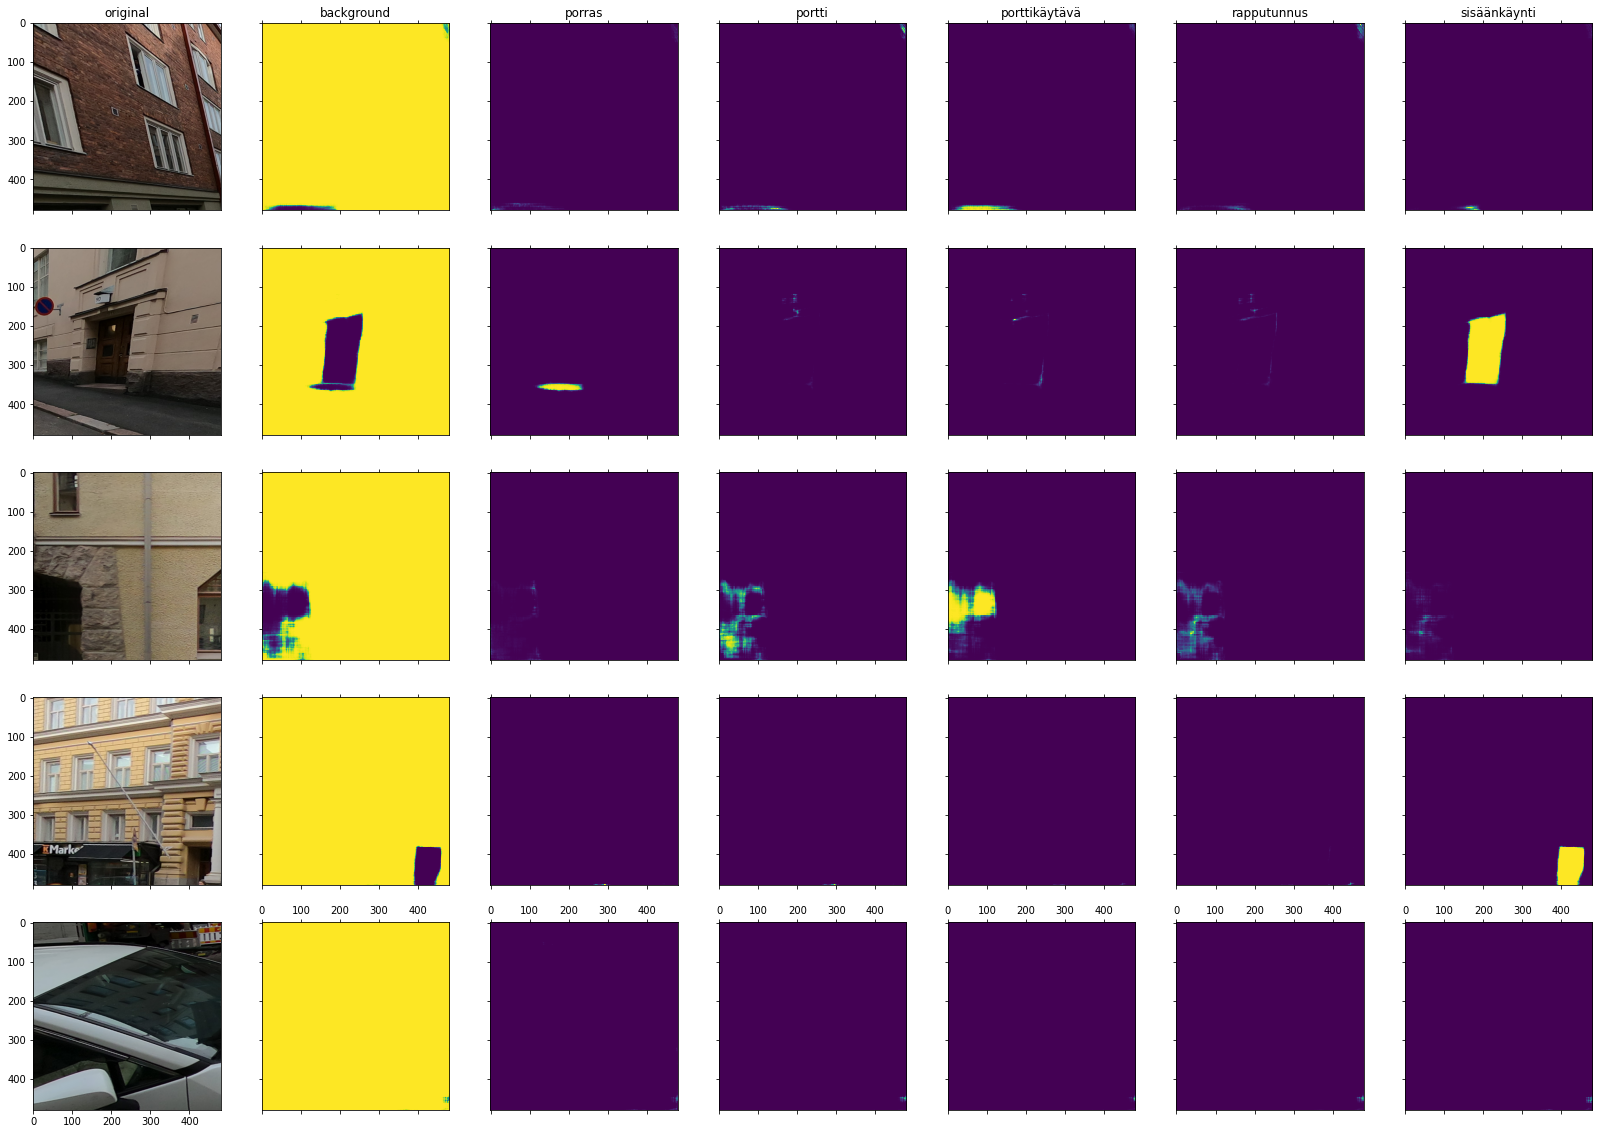

In [54]:
X, _ = next(gen)
res = model.predict(X)

print(f'Indexes {predict_index}-{predict_index+4}')
predict_index += 5
fig, axs = plt.subplots(data_generator_options['batch_size'], 7, figsize=(7*4, data_generator_options['batch_size']*4), sharex=True, sharey=True)

axs[0][0].set_title('original')
for i, key in enumerate(label_rgbs.keys()):
    axs[0][i + 1].set_title(key)

for j in range(0, data_generator_options['batch_size']):
    axs[j][0].imshow(X[j])

for i in range(1, 7):
    for j in range(0, data_generator_options['batch_size']):
        axs[j][i].matshow(res[j][:,:,i-1])

90-94

In [64]:
test2 = X

# Checks, backups etc

Cells here are meant as an exploration-left-as-reminders.

### Test label_to_target_map

In [347]:
test_set = [
    '20210914-kruununhaka_GSAE0447.png',
    '20210914-kruununhaka_GSAE0448.png',
    '20210914-kruununhaka_GSAE0449.png',
    '20210914-kruununhaka_GSAE0450.png',
    '20210914-kruununhaka_GSAE0451.png',
    '20210914-kruununhaka_GSAE0452.png',
    '20210914-kruununhaka_GSAE0453.png',
]
img_iter = iter(test_set)

In [371]:
label_filename = next(img_iter)
label_filepath = f'labels/2021-12-18/SegmentationClass/{label_filename}'
target_filepath = f'data_360/images/{label_to_target_map[label_filename]["image"]}'

bg = Image.open(target_filepath).convert('RGBA')
fg = Image.open(label_filepath).convert('RGBA')

Image.blend(bg, fg, 0.5)

StopIteration: 

### Test data generator

In [422]:
data_generator = DataGenerator(
    list_IDs = test_set,
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    **data_generator_options,
    debug = True,
    augment = True
)
gen = data_generator.__iter__()

Loaded target 20210914-kruununhaka_GSAE0447.JPG, label 20210914-kruununhaka_GSAE0447.png.


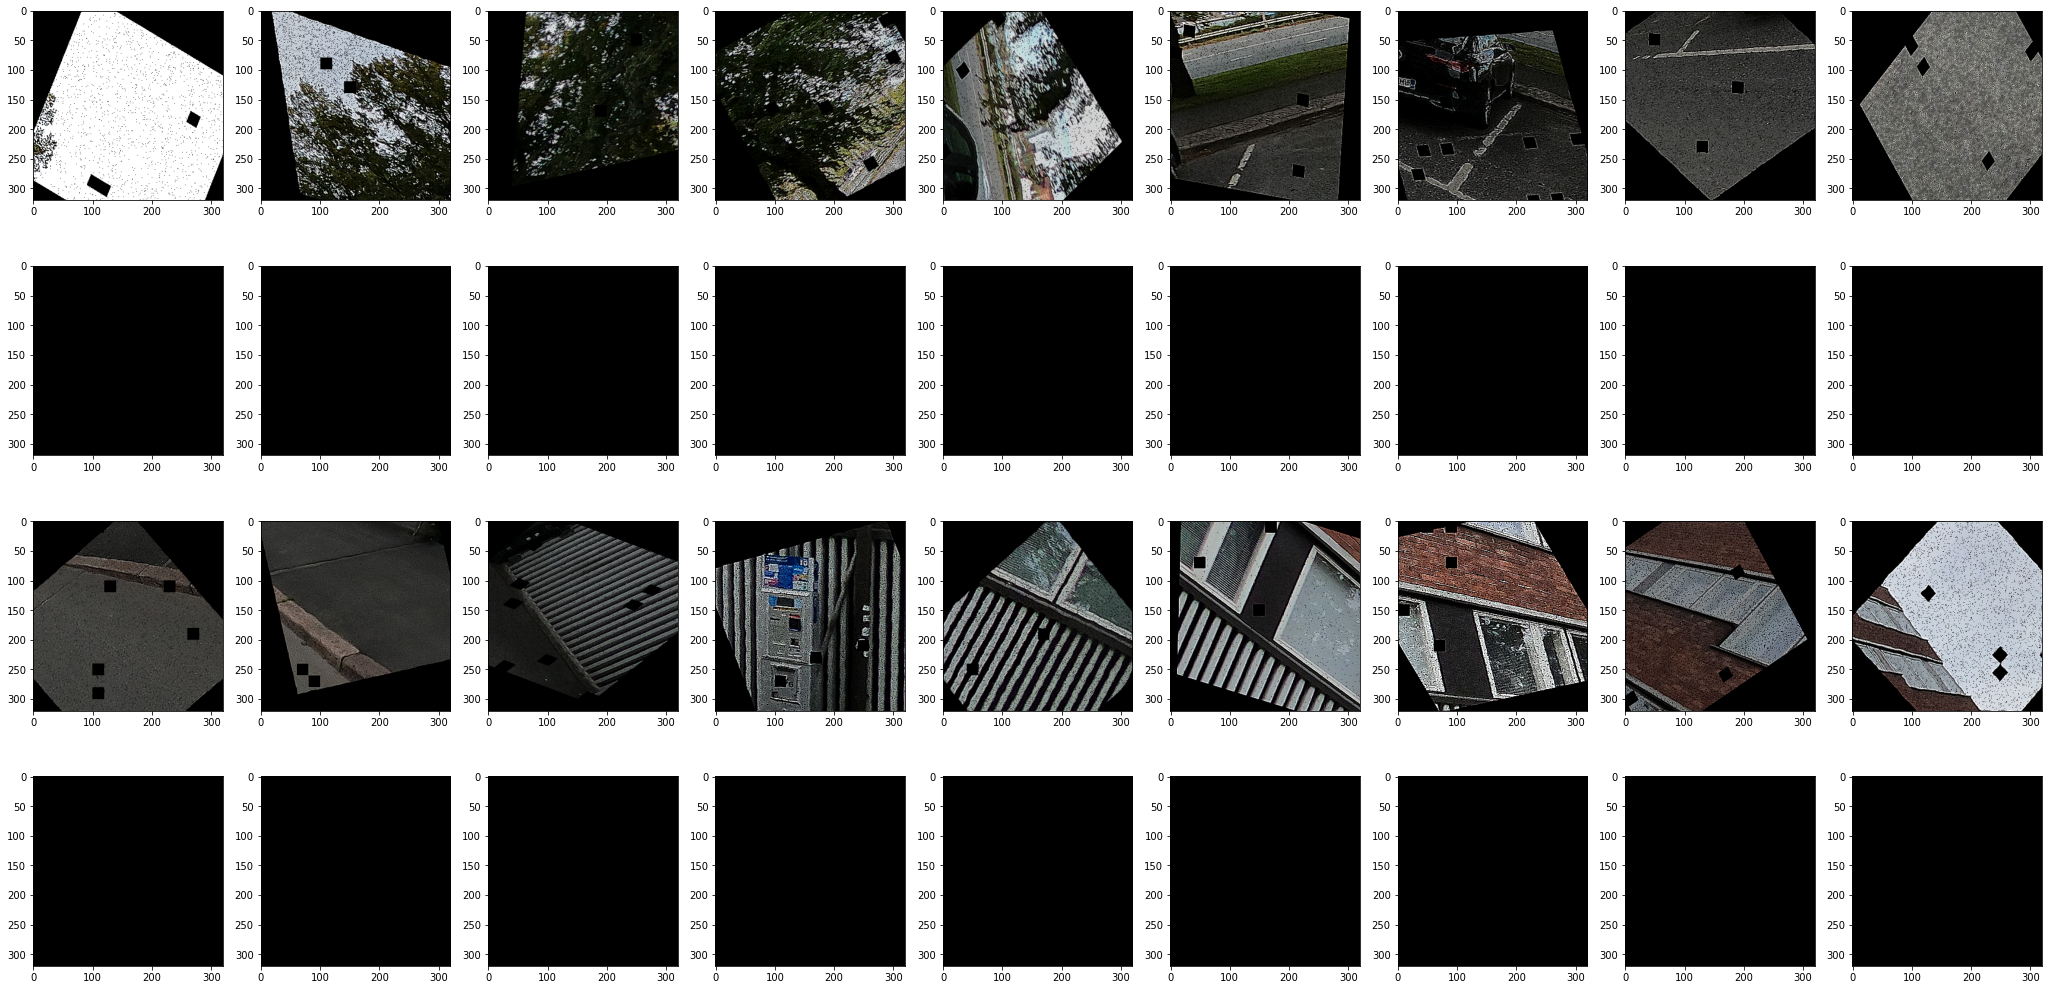

In [421]:
X, y = next(gen)

n = X.shape[0]
mid = n//2
fig, axs = plt.subplots(4, mid, figsize = (n * 2, 18))

for i in range(0, mid):
    axs[0][i].imshow(X[i]/255)
    axs[1][i].imshow(y[i]/255)
for i in range(0, mid):
    axs[2][i].imshow(X[mid + i]/255)
    axs[3][i].imshow(y[mid + i]/255)
                     

In [111]:
label_rgbs

{'background': [0, 0, 0],
 'porras': [255, 106, 77],
 'portti': [51, 221, 255],
 'porttikäytävä': [255, 204, 51],
 'rapputunnus': [131, 224, 112],
 'sisäänkäynti': [61, 61, 245]}

In [ ]:
i = 0
end = data_generator.__len__()
for X, _ in gen:
    preds = model.predict(X)
    if np.min(preds) < 0 or np.max(preds) > 1:
        print('Somewhere, something produced a shitty prediction')
        print(np.min(preds))
        print(np.max(preds))
    i += 1
    print(f'{i}/{end}', end="")
    print('\r', end="")

For future sake: the above did not find any errors

### Check that labels do not contain negative values

P.S. this takes a *long* time 

In [ ]:
def check_labels_and_targets():
    label_paths = [ f'{label_directory}{label_filename}' for label_filename in os.listdir(label_directory) if label_filename[-4:] == ".png"]
    target_paths = [ f'{target_directory}{target_filename}' for target_filename in os.listdir(target_directory) if target_filename[-4:] == ".JPG"]
    total = len(label_paths) + len(target_paths)
    i = 0
    for target_path in target_paths:
        img_arr = np.asarray(Image.open(target_path))
        if img_arr.shape != (2880, 5760, 3):
            print(f'Weird target shape: {img_arr.shape}, target {target_path}')
        if np.min(img_arr) < 0 or np.max(img_arr) > 255:
            print(f'Found weird target: {target_path}')
        i += 1
        print(f'{i} / {total}', end='')
        print('\r', end='')
    for label_path in label_paths:
        img_arr = np.asarray(Image.open(label_path))
        if img_arr.shape != (2880, 5760, 3):
            print(f'Weird label shape: {img_arr.shape}, label {label_path}')
        if np.min(img_arr) < 0 or np.max(img_arr) > 255:
            print(f'Found weird label: {label_path}')
        i += 1
        print(f'{i} / {total}', end='')
        print('\r', end='')
            
check_labels_and_targets()

For future's sake: the above did not find any errors

### Check that patchfiy works

In [ ]:
img = Image.open('data_360/20210914-kruununhaka_GSAD0219.JPG')
img_arr = np.asarray(img)
#img

In [ ]:
import patchify
from matplotlib import pyplot as plt
patches = patchify.patchify(img_arr, (720, 720, 3), step=720).reshape(32, 720, 720, 3)
fig, axs = plt.subplots(4, 8, figsize=(16, 16), sharex=True, sharey=True, ) 
for i in range(0, 4):
    for j in range(0, 8):
        patch = i * 8 + j
        axs[i][j].imshow(patches[patch], interpolation='nearest')
#plt.show()

### Size checks

In [53]:
img = Image.open('data_360/20210914-kruununhaka_GSAD0219.JPG')
img_arr = np.asarray(img)
img_arr.shape

(2880, 5760, 3)

In [263]:
for i in range(320, 800):
    if 2880 % i == 0 and 5760 % i == 0:
        print(i)

320
360
480
576
720


### Test imgaug

In [31]:
target_filename = '20210914-kruununhaka_GSAE0480.JPG'
label_filename = target_filename.replace('.JPG', '.png')
target_filepath = f'./data_360/images/{target_filename}'
label_filepath = f'./labels/SegmentationClass/{label_filename}'


target = np.asarray(Image.open(target_filepath))
label = np.asarray(Image.open(label_filepath))
segmap = imgaug.augmentables.segmaps.SegmentationMapsOnImage(label, shape=label.shape)

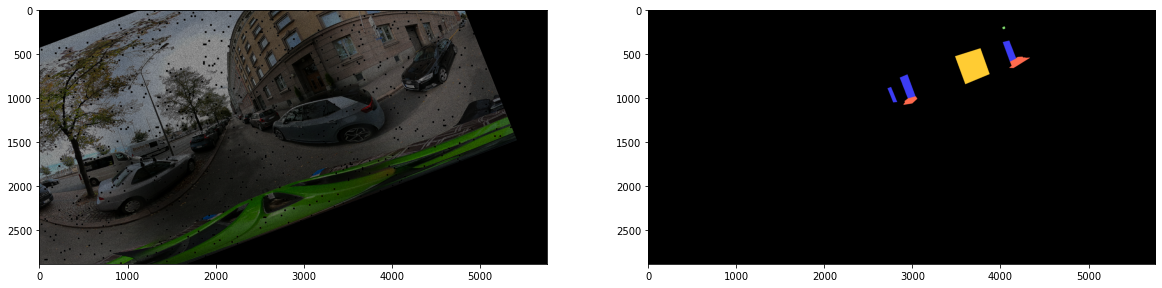

In [63]:
affine_translation_opts = {
    'rotate': (-45, 45),
    'translate_percent': {
        'x': (-0.2, 0.2),
        'y': (-0.2, 0.2)
    },
    'shear': {
        'x': (-20, 20),
        'y': (-20, 20)
    }
}

augment_sequence = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Dropout([0.05, 0.2]),
    iaa.Sharpen([0.0, 1.0]),
    iaa.Affine(**affine_translation_opts),
    iaa.ElasticTransformation(alpha=(0, 10), sigma=5),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout(0.02, size_percent=0.05)
], random_order = True)

img_augmented = augment_sequence(image = target, segmentation_maps = segmap)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(img_augmented[0])
ax2.imshow(img_augmented[1].arr)

### Backups and tests

In [ ]:
    def __index_to_img_patch_index_backup__(self, index):
        """
        Translate index into image number, patch number.
        For example, if 
            batch size = 512x512,
            original image dimensions = 1024x1024
        there are 4 patches per image, and a call to index_to_img_patch_index(7) would
        return (1, 2) because we need to take the third patch of the second image
        (and indexing starts from 0)
        """
        batches_in_image = self.__n_patches_in_single_image__()
        image_index = index // batches_in_image
        patch_index = (index % batches_in_image)
        return((image_index, patch_index))

    def __getitem_backup__(self, index):
        """
        Generate one batch

        @index is the number of the batch
        """
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size - 1
        start = self.__index_to_img_patch_index__(start_index)
        end = self.__index_to_img_patch_index__(end_index)

        image_indexes = range(start[0], end[0] + 1)
        img_ids = [self.list_IDs[k] for k in image_indexes]
        X, y = self.__data_generation__(next_list_IDs, index)
        return X, y

    def __data_generation_backup__(self, next_list_IDs, index):
        cur_batch_size = self.batch_size

        # last batch might not be a full batch
        targets_remaining_in_epoch = len(self.list_IDs) - (index * self.batch_size)
        if targets_remaining_in_epoch < self.batch_size:
            cur_batch_size = targets_remaining_in_epoch

        patches_in_batch = self.__n_patches_in_single_image__() * cur_batch_size
        X = np.empty((patches_in_batch, self.patch_size_square, self.patch_size_square, self.n_channels))
        y = np.empty((patches_in_batch, self.patch_size_square, self.patch_size_square, self.num_target_classes))

        for i, id in enumerate(next_list_IDs):
            target_filepath = f'{self.target_directory}/{label_filename.replace(".png", ".JPG")}'
            label_filepath = f'{self.label_directory}/{label_filename}'
            target_img = np.asarray(Image.open(target_filepath)) / 255
            label_img = np.asarray(Image.open(label_filepath))

            # Create patches
            target_patches = keras_unet.utils.get_patches(img_arr=target_img, size=self.patch_size_square, stride=self.patch_size_square)
            label_patches = keras_unet.utils.get_patches(img_arr=label_img, size=self.patch_size_square, stride=self.patch_size_square)
            for j, target_patch in enumerate(target_patches):
                patch_index = i * patches_in_image_x + j
                label_patch = self.rgb_to_onehot(label_patches[j])
                X[patch_index,] = target_patch
                y[patch_index,] = label_patch
        return X, y



### Data generation

In [ ]:
index = 0
images_to_load = [{'img_index': 0, 'patch_start': 0, 'patch_end': 1, 'image': '20210914-kruununhaka_GSAD0314.png'}]
batch_size = 2
patch_size_square = 720
n_channels = 3
num_target_classes = 6
target_directory = './data_360/images/'
label_directory = './labels/SegmentationClass/'
original_image_dimensions = (5760, 2880)
label_rgbss = list(label_rgbs.values())
label_onehot = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
]

def rgb_to_onehot(img): 
    layout_x, layout_y, _ = img.shape
    layout = np.zeros((layout_x, layout_y, len(label_onehot[0])))
    for i, label in enumerate(label_rgbss):
        layout[np.all(img == label, axis = -1)] = label_onehot[i]
    return layout

def __n_patches_in_single_image__():
    return 32

def data_generation(images_to_load, index):
    print(images_to_load, index)
    X = np.empty((batch_size, patch_size_square, patch_size_square, n_channels))
    y = np.empty((batch_size, patch_size_square, patch_size_square, num_target_classes))

    patches_in_single_image = __n_patches_in_single_image__()

    patch_index = 0
    for i, image_to_load in enumerate(images_to_load):
        target_filepath = f'{target_directory}{image_to_load["image"].replace(".png", ".JPG")}'
        label_filepath = f'{label_directory}{image_to_load["image"]}'
        target_img = np.asarray(Image.open(target_filepath)) / 255
        label_img = np.asarray(Image.open(label_filepath))

        # Create patches

        whole_target_image_patched = patchify.patchify(target_img, (patch_size_square, patch_size_square, 3), step=patch_size_square).reshape(patches_in_single_image, patch_size_square, patch_size_square, 3)
        whole_label_image_patched = patchify.patchify(label_img, (patch_size_square, patch_size_square, 3), step=patch_size_square).reshape(patches_in_single_image, patch_size_square, patch_size_square, 3)

        target_patches = whole_target_image_patched[image_to_load['patch_start']:image_to_load['patch_end']]
        label_patches = whole_label_image_patched[image_to_load['patch_start']:image_to_load['patch_end']]
        patches_in_image_x = original_image_dimensions[0] // patch_size_square

        for j, target_patch in enumerate(target_patches):
            label_patch = rgb_to_onehot(label_patches[j])
            X[patch_index,] = target_patch
            y[patch_index,] = label_patch
            patch_index += 1
    return X, y
X, y = data_generation(images_to_load, index)

#Image.open(f'{target_directory}{images_to_load[0]["image"].replace(".png", ".JPG")}')

# Test .npy data generator

Remember to run the npy data formatters first

In [173]:
data_generator_options = {
    'original_image_dimensions': (5760, 2880),
    'patch_size_square': input_shape[0],
    'batch_size': 5,
    'data_format': 'npy'
}

data_generator = DataGenerator(
    list_IDs = partition["train"],
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    **data_generator_options,
    debug=True,
    augment=True
)
gen = data_generator.__iter__()

In [182]:
X, Y = next(gen)
X.shape

Loaded target /home/emblica/code/forumvirium/targets/2021-12-27/20210914-kruununhaka_GSAI1315-04.npz, label /home/emblica/code/forumvirium/labels/2021-12-27/SegmentationClass/20210914-kruununhaka_GSAI1315-04.npz.
Loaded target /home/emblica/code/forumvirium/targets/2021-12-27/20210914-kruununhaka_GSAE0594-03.npz, label /home/emblica/code/forumvirium/labels/2021-12-27/SegmentationClass/20210914-kruununhaka_GSAE0594-03.npz.
Loaded target /home/emblica/code/forumvirium/targets/2021-12-27/20210914-kruununhaka_GSAH0879-04.npz, label /home/emblica/code/forumvirium/labels/2021-12-27/SegmentationClass/20210914-kruununhaka_GSAH0879-04.npz.
Loaded target /home/emblica/code/forumvirium/targets/2021-12-27/20210914-kruununhaka_GSAI1208-00.npz, label /home/emblica/code/forumvirium/labels/2021-12-27/SegmentationClass/20210914-kruununhaka_GSAI1208-00.npz.
Loaded target /home/emblica/code/forumvirium/targets/2021-12-27/20210914-kruununhaka_GSAI1230-05.npz, label /home/emblica/code/forumvirium/labels/20

(5, 480, 480, 3)

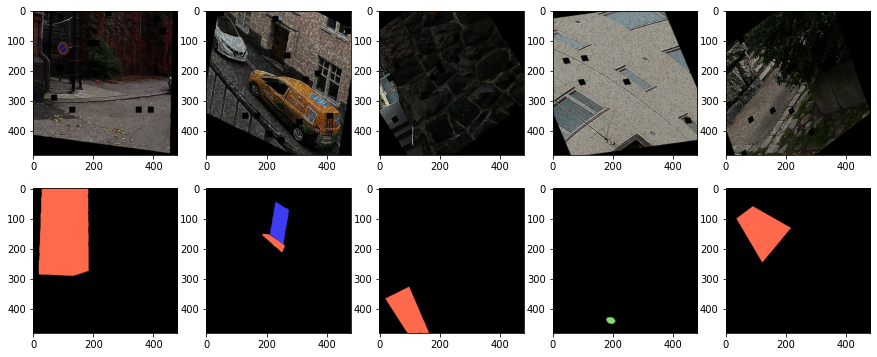

In [183]:
fig, axs = plt.subplots(2, X.shape[0], figsize=(3*X.shape[0], 6))
for i in range(0, X.shape[0]):
    axs[0][i].imshow(X[i])
    axs[1][i].imshow(Y[i]/255)